In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import time
import pandas as pd
import io

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist
import sys
ros_path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if ros_path in sys.path:
    sys.path.remove(ros_path)
import cv2

import yaml
from layers import *

In [2]:
model_name = "mono+stereo_1024x320"
data_dir = "/media/ferdyan/LocalDiskE/Hasil/dataset/Final/7/"

# download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False).cuda()
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4)).cuda()

loaded_dict_enc = torch.load(encoder_path)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

depth_decoder.load_state_dict(torch.load(depth_decoder_path))

encoder.eval()
depth_decoder.eval()

pose_encoder_path = os.path.join("models", model_name, "pose_encoder.pth")
pose_decoder_path = os.path.join("models", model_name, "pose.pth")

pose_encoder = networks.ResnetEncoder(18, False, 2).cuda()
pose_encoder.load_state_dict(torch.load(pose_encoder_path))

pose_decoder = networks.PoseDecoder(pose_encoder.num_ch_enc, 1, 2).cuda()
pose_decoder.load_state_dict(torch.load(pose_decoder_path))

pose_encoder.eval()
pose_decoder.eval();

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']

# Prediction pose
prev_img = None
orig = np.array([0, 0, 0, 1])
pos_pred = [orig.copy()]
pos_pred_g = [orig.copy()]

image_dir = data_dir+'/Images'
T_pred = []
T_pr = np.eye(4)
T_guanyipr = np.eye(4)

In [3]:
for i, filename in enumerate(sorted(os.listdir(image_dir))):
    image_path = os.path.join(image_dir, filename)
    print("image_path = ", image_path)

    input_image = pil.open(image_path).convert('RGB')
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)
    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0).cuda()

    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)
        disp = outputs[("disp", 0)][0]

        if prev_img is not None:
            features_pose = [pose_encoder(torch.cat([prev_img, input_image_pytorch], 1))]
            axisangle, translation = pose_decoder(features_pose)
            T_ = transformation_from_parameters(axisangle[:, 0], translation[:, 0], True).cpu().numpy()[0]
            T_guanyi = np.hstack(np.squeeze(transformation_from_parameters(axisangle[:, 0], translation[:, 0]).cpu().numpy())[:3])

            T_pr = T_pr.dot(T_)
            T_pred += [T_]
            pos_pred += [T_pr[:,-1]]

    print("T_pr = ", T_pr)
    print("")

    disp_np = disp.squeeze().cpu().numpy()
    vmax = np.percentile(disp_np, 95)
    output = np.zeros((feed_height, feed_width*2+320, 3), dtype=np.uint8)
    buf = io.BytesIO()
    plt.imsave(buf, disp_np, cmap='plasma', vmax=vmax)
    buf.seek(0)
    disp_ = np.array(pil.open(buf))[:,:,:3]
    buf.close()
    
    plt.figure(figsize=(5, 4))
    plt.title("Visual odometry", fontsize=15)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='datalim')
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')

    scale = 29.5
    pos_pred_ = np.array(pos_pred)*scale
    plt.plot(pos_pred_[:, 0], pos_pred_[:, 2], 'o-', label='pred')
    plt.scatter(pos_pred_[-1, 0], pos_pred_[-1, 2], color='r', s=100, zorder=10)
    plt.text(pos_pred_[-1, 0], pos_pred_[-1, 2], 'NOW', fontsize=15, zorder=20)
    plt.legend(loc=4, fontsize=15)
    buf = io.BytesIO()
    plt.savefig(buf, dpi=64)
    plt.close()
    buf.seek(0)
    vo = np.array(pil.open(buf))[:,:,:3]
    buf.close()
    
    output[:,:feed_width] = np.array(input_image_resized)
    output[:,feed_width:-320] = disp_
    #output[:,-320:] = vo
    #out.write(output[:,:,::-1])
    
    prev_img = input_image_pytorch

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0000.png
T_pr =  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0001.png
T_pr =  [[ 9.99999881e-01  1.08534667e-04 -4.71180800e-04 -1.08447287e-03]
 [-1.08628657e-04  1.00000000e+00 -2.46539275e-04 -3.19508763e-05]
 [ 4.71159146e-04  2.46580661e-04  9.99999881e-01  3.38587947e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0002.png
T_pr =  [[ 9.99999615e-01 -4.00282370e-04 -7.73079662e-04 -1.66692426e-03]
 [ 3.99272809e-04  9.99999075e-01 -1.32227040e-03 -3.10630237e-04]
 [ 7.73628902e-04  1.32194707e-03  9.99998818e-01  8.14501121e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0003.png
T_pr =  [[ 9.99999604e-01 -1.22637577e-04 -8.54109655e-04 

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0025.png
T_pr =  [[ 9.99980662e-01  1.67988253e-04 -6.22906890e-03 -2.59413281e-02]
 [-3.21886527e-04  9.99694363e-01 -2.47130938e-02 -2.40434507e-02]
 [ 6.22303257e-03  2.47146180e-02  9.99675037e-01  1.07759638e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0026.png
T_pr =  [[ 9.99982386e-01  4.27344721e-04 -5.93595762e-03 -2.69593385e-02]
 [-5.79093004e-04  9.99672260e-01 -2.55870742e-02 -2.46781173e-02]
 [ 5.92308866e-03  2.55900546e-02  9.99654840e-01  1.10810630e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0027.png
T_pr =  [[ 9.99985678e-01  8.53601790e-04 -5.30122546e-03 -2.76850846e-02]
 [-9.96060090e-04  9.99636664e-01 -2.69289769e-02 -2.57702674e-02]
 [ 5.27632570e-03  2.69338649e-02  9.99623188e-01  1.15021042e+00

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0050.png
T_pr =  [[ 9.99956850e-01 -1.47770555e-03 -9.18900904e-03 -5.45088899e-02]
 [ 1.06435885e-03  9.98994001e-01 -4.48290816e-02 -5.83997799e-02]
 [ 9.24609579e-03  4.48172657e-02  9.98952335e-01  2.11241952e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0051.png
T_pr =  [[ 9.99872777e-01 -6.66246515e-04 -1.59477759e-02 -5.64962656e-02]
 [-7.14850231e-05  9.98931344e-01 -4.62162412e-02 -6.11164842e-02]
 [ 1.59616116e-02  4.62113938e-02  9.98804105e-01  2.15911321e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0052.png
T_pr =  [[ 9.99808074e-01 -9.96288324e-04 -1.95755578e-02 -5.86271434e-02]
 [ 6.12041495e-05  9.98860965e-01 -4.77126561e-02 -6.32182386e-02]
 [ 1.96008828e-02  4.77021910e-02  9.98669241e-01  2.19762979e+00

T_pr =  [[ 9.89927602e-01 -2.65221366e-04 -1.41573927e-01 -1.72118113e-01]
 [-1.04285199e-02  9.97144987e-01 -7.47875191e-02 -1.35388911e-01]
 [ 1.41189601e-01  7.55105990e-02  9.87098536e-01  3.15692479e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0074.png
T_pr =  [[ 9.88893413e-01 -1.17665281e-03 -1.48621483e-01 -1.82647227e-01]
 [-1.02471562e-02  9.97049387e-01 -7.60760760e-02 -1.40587296e-01]
 [ 1.48272514e-01  7.67540398e-02  9.85963428e-01  3.21264643e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

image_path =  /media/ferdyan/LocalDiskE/Hasil/dataset/Final/7//Images/0075.png
T_pr =  [[ 9.87433116e-01 -1.25006580e-03 -1.58032220e-01 -1.97499344e-01]
 [-1.12621265e-02  9.96869789e-01 -7.82546655e-02 -1.48038747e-01]
 [ 1.57635409e-01  7.90509863e-02  9.84328115e-01  3.28931687e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

image_pa

In [4]:
pos_pred

[array([0, 0, 0, 1]),
 array([-1.08447287e-03, -3.19508763e-05,  3.38587947e-02,  1.00000000e+00]),
 array([-1.66692426e-03, -3.10630237e-04,  8.14501121e-02,  1.00000000e+00]),
 array([-2.55846506e-03, -3.43672739e-04,  1.12194070e-01,  1.00000000e+00]),
 array([-0.00358565, -0.00124216,  0.18621018,  1.        ]),
 array([-0.00469066, -0.00197681,  0.24316336,  1.        ]),
 array([-0.0057114 , -0.00238059,  0.28172771,  1.        ]),
 array([-0.00695504, -0.00294698,  0.32228819,  1.        ]),
 array([-0.0077535 , -0.00294205,  0.33936768,  1.        ]),
 array([-0.00935819, -0.00553413,  0.44553174,  1.        ]),
 array([-0.01015385, -0.00552521,  0.4586604 ,  1.        ]),
 array([-0.01051297, -0.00580573,  0.48280462,  1.        ]),
 array([-0.01139071, -0.00602753,  0.50251913,  1.        ]),
 array([-0.01217647, -0.00636596,  0.51980124,  1.        ]),
 array([-0.01240242, -0.00682085,  0.54408995,  1.        ]),
 array([-0.01290798, -0.00786126,  0.58432348,  1.        ]),


pos_pred =  [array([0, 0, 0, 1]), array([-1.08447287e-03, -3.19508763e-05,  3.38587947e-02,  1.00000000e+00]), array([-1.66692426e-03, -3.10630237e-04,  8.14501121e-02,  1.00000000e+00]), array([-2.55846506e-03, -3.43672739e-04,  1.12194070e-01,  1.00000000e+00]), array([-0.00358565, -0.00124216,  0.18621018,  1.        ]), array([-0.00469066, -0.00197681,  0.24316336,  1.        ]), array([-0.0057114 , -0.00238059,  0.28172771,  1.        ]), array([-0.00695504, -0.00294698,  0.32228819,  1.        ]), array([-0.0077535 , -0.00294205,  0.33936768,  1.        ]), array([-0.00935819, -0.00553413,  0.44553174,  1.        ]), array([-0.01015385, -0.00552521,  0.4586604 ,  1.        ]), array([-0.01051297, -0.00580573,  0.48280462,  1.        ]), array([-0.01139071, -0.00602753,  0.50251913,  1.        ]), array([-0.01217647, -0.00636596,  0.51980124,  1.        ]), array([-0.01240242, -0.00682085,  0.54408995,  1.        ]), array([-0.01290798, -0.00786126,  0.58432348,  1.        ]), arr

pos_pred =  [array([0, 0, 0, 1]), array([-1.08447287e-03, -3.19508763e-05,  3.38587947e-02,  1.00000000e+00]), array([-1.66692426e-03, -3.10630237e-04,  8.14501121e-02,  1.00000000e+00]), array([-2.55846506e-03, -3.43672739e-04,  1.12194070e-01,  1.00000000e+00]), array([-0.00358565, -0.00124216,  0.18621018,  1.        ]), array([-0.00469066, -0.00197681,  0.24316336,  1.        ]), array([-0.0057114 , -0.00238059,  0.28172771,  1.        ]), array([-0.00695504, -0.00294698,  0.32228819,  1.        ]), array([-0.0077535 , -0.00294205,  0.33936768,  1.        ]), array([-0.00935819, -0.00553413,  0.44553174,  1.        ]), array([-0.01015385, -0.00552521,  0.4586604 ,  1.        ]), array([-0.01051297, -0.00580573,  0.48280462,  1.        ]), array([-0.01139071, -0.00602753,  0.50251913,  1.        ]), array([-0.01217647, -0.00636596,  0.51980124,  1.        ]), array([-0.01240242, -0.00682085,  0.54408995,  1.        ]), array([-0.01290798, -0.00786126,  0.58432348,  1.        ]), arr

pos_pred =  [array([0, 0, 0, 1]), array([-1.08447287e-03, -3.19508763e-05,  3.38587947e-02,  1.00000000e+00]), array([-1.66692426e-03, -3.10630237e-04,  8.14501121e-02,  1.00000000e+00]), array([-2.55846506e-03, -3.43672739e-04,  1.12194070e-01,  1.00000000e+00]), array([-0.00358565, -0.00124216,  0.18621018,  1.        ]), array([-0.00469066, -0.00197681,  0.24316336,  1.        ]), array([-0.0057114 , -0.00238059,  0.28172771,  1.        ]), array([-0.00695504, -0.00294698,  0.32228819,  1.        ]), array([-0.0077535 , -0.00294205,  0.33936768,  1.        ]), array([-0.00935819, -0.00553413,  0.44553174,  1.        ]), array([-0.01015385, -0.00552521,  0.4586604 ,  1.        ]), array([-0.01051297, -0.00580573,  0.48280462,  1.        ]), array([-0.01139071, -0.00602753,  0.50251913,  1.        ]), array([-0.01217647, -0.00636596,  0.51980124,  1.        ]), array([-0.01240242, -0.00682085,  0.54408995,  1.        ]), array([-0.01290798, -0.00786126,  0.58432348,  1.        ]), arr

pos_pred =  [array([0, 0, 0, 1]), array([-1.08447287e-03, -3.19508763e-05,  3.38587947e-02,  1.00000000e+00]), array([-1.66692426e-03, -3.10630237e-04,  8.14501121e-02,  1.00000000e+00]), array([-2.55846506e-03, -3.43672739e-04,  1.12194070e-01,  1.00000000e+00]), array([-0.00358565, -0.00124216,  0.18621018,  1.        ]), array([-0.00469066, -0.00197681,  0.24316336,  1.        ]), array([-0.0057114 , -0.00238059,  0.28172771,  1.        ]), array([-0.00695504, -0.00294698,  0.32228819,  1.        ]), array([-0.0077535 , -0.00294205,  0.33936768,  1.        ]), array([-0.00935819, -0.00553413,  0.44553174,  1.        ]), array([-0.01015385, -0.00552521,  0.4586604 ,  1.        ]), array([-0.01051297, -0.00580573,  0.48280462,  1.        ]), array([-0.01139071, -0.00602753,  0.50251913,  1.        ]), array([-0.01217647, -0.00636596,  0.51980124,  1.        ]), array([-0.01240242, -0.00682085,  0.54408995,  1.        ]), array([-0.01290798, -0.00786126,  0.58432348,  1.        ]), arr

pos_pred =  [array([0, 0, 0, 1]), array([-1.08447287e-03, -3.19508763e-05,  3.38587947e-02,  1.00000000e+00]), array([-1.66692426e-03, -3.10630237e-04,  8.14501121e-02,  1.00000000e+00]), array([-2.55846506e-03, -3.43672739e-04,  1.12194070e-01,  1.00000000e+00]), array([-0.00358565, -0.00124216,  0.18621018,  1.        ]), array([-0.00469066, -0.00197681,  0.24316336,  1.        ]), array([-0.0057114 , -0.00238059,  0.28172771,  1.        ]), array([-0.00695504, -0.00294698,  0.32228819,  1.        ]), array([-0.0077535 , -0.00294205,  0.33936768,  1.        ]), array([-0.00935819, -0.00553413,  0.44553174,  1.        ]), array([-0.01015385, -0.00552521,  0.4586604 ,  1.        ]), array([-0.01051297, -0.00580573,  0.48280462,  1.        ]), array([-0.01139071, -0.00602753,  0.50251913,  1.        ]), array([-0.01217647, -0.00636596,  0.51980124,  1.        ]), array([-0.01240242, -0.00682085,  0.54408995,  1.        ]), array([-0.01290798, -0.00786126,  0.58432348,  1.        ]), arr

pos_pred =  [array([0, 0, 0, 1]), array([-1.08447287e-03, -3.19508763e-05,  3.38587947e-02,  1.00000000e+00]), array([-1.66692426e-03, -3.10630237e-04,  8.14501121e-02,  1.00000000e+00]), array([-2.55846506e-03, -3.43672739e-04,  1.12194070e-01,  1.00000000e+00]), array([-0.00358565, -0.00124216,  0.18621018,  1.        ]), array([-0.00469066, -0.00197681,  0.24316336,  1.        ]), array([-0.0057114 , -0.00238059,  0.28172771,  1.        ]), array([-0.00695504, -0.00294698,  0.32228819,  1.        ]), array([-0.0077535 , -0.00294205,  0.33936768,  1.        ]), array([-0.00935819, -0.00553413,  0.44553174,  1.        ]), array([-0.01015385, -0.00552521,  0.4586604 ,  1.        ]), array([-0.01051297, -0.00580573,  0.48280462,  1.        ]), array([-0.01139071, -0.00602753,  0.50251913,  1.        ]), array([-0.01217647, -0.00636596,  0.51980124,  1.        ]), array([-0.01240242, -0.00682085,  0.54408995,  1.        ]), array([-0.01290798, -0.00786126,  0.58432348,  1.        ]), arr

pos_pred =  [array([0, 0, 0, 1]), array([-1.08447287e-03, -3.19508763e-05,  3.38587947e-02,  1.00000000e+00]), array([-1.66692426e-03, -3.10630237e-04,  8.14501121e-02,  1.00000000e+00]), array([-2.55846506e-03, -3.43672739e-04,  1.12194070e-01,  1.00000000e+00]), array([-0.00358565, -0.00124216,  0.18621018,  1.        ]), array([-0.00469066, -0.00197681,  0.24316336,  1.        ]), array([-0.0057114 , -0.00238059,  0.28172771,  1.        ]), array([-0.00695504, -0.00294698,  0.32228819,  1.        ]), array([-0.0077535 , -0.00294205,  0.33936768,  1.        ]), array([-0.00935819, -0.00553413,  0.44553174,  1.        ]), array([-0.01015385, -0.00552521,  0.4586604 ,  1.        ]), array([-0.01051297, -0.00580573,  0.48280462,  1.        ]), array([-0.01139071, -0.00602753,  0.50251913,  1.        ]), array([-0.01217647, -0.00636596,  0.51980124,  1.        ]), array([-0.01240242, -0.00682085,  0.54408995,  1.        ]), array([-0.01290798, -0.00786126,  0.58432348,  1.        ]), arr

pos_pred =  [array([0, 0, 0, 1]), array([-1.08447287e-03, -3.19508763e-05,  3.38587947e-02,  1.00000000e+00]), array([-1.66692426e-03, -3.10630237e-04,  8.14501121e-02,  1.00000000e+00]), array([-2.55846506e-03, -3.43672739e-04,  1.12194070e-01,  1.00000000e+00]), array([-0.00358565, -0.00124216,  0.18621018,  1.        ]), array([-0.00469066, -0.00197681,  0.24316336,  1.        ]), array([-0.0057114 , -0.00238059,  0.28172771,  1.        ]), array([-0.00695504, -0.00294698,  0.32228819,  1.        ]), array([-0.0077535 , -0.00294205,  0.33936768,  1.        ]), array([-0.00935819, -0.00553413,  0.44553174,  1.        ]), array([-0.01015385, -0.00552521,  0.4586604 ,  1.        ]), array([-0.01051297, -0.00580573,  0.48280462,  1.        ]), array([-0.01139071, -0.00602753,  0.50251913,  1.        ]), array([-0.01217647, -0.00636596,  0.51980124,  1.        ]), array([-0.01240242, -0.00682085,  0.54408995,  1.        ]), array([-0.01290798, -0.00786126,  0.58432348,  1.        ]), arr

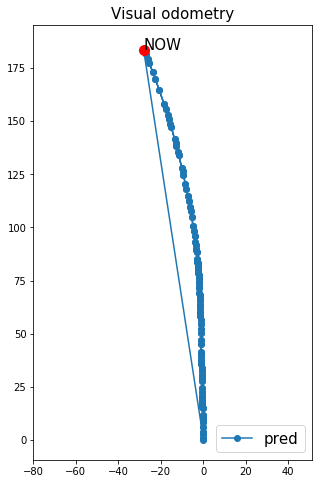

In [5]:
T_pr = np.eye(4)
for i in range(1, len(pos_pred)):
    T_pr = T_pr.dot(T_pred[i-1])
    pos_pred += [T_pr[:,-1]]
    print("pos_pred = ", pos_pred)
    
plt.figure(figsize=(5, 8))
plt.title("Visual odometry", fontsize=15)
ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')
scale = 34.169
pos_pred = np.array(pos_pred)*scale
plt.plot(pos_pred[:, 0], pos_pred[:, 2], '-o', label='pred')
plt.scatter(pos_pred[-1, 0], pos_pred[-1, 2], color='r', s=100, zorder=10)
plt.text(pos_pred[-1, 0], pos_pred[-1, 2], 'NOW', fontsize=15, zorder=20)
plt.legend(loc=4, fontsize=15)

buf = io.BytesIO()
plt.savefig(buf, dpi=64)
# plt.close()
buf.seek(0)
x = np.array(pil.open(buf))[:,:,:3]
buf.close()